## <div class="alert alert-success"> <span style='color:Green'> PCS5042 - Inteligência Artificial Informada por Leis Físicas e Modelos de Ordem Reduzida para Engenharia (2022) - EP3 - OpenINF KS
 <div class="alert alert-success"> <span style='color:Green'> Alunos: Pedro Paludetto Lopes da Silva e Nathália Nunes Araújo </span>

Para este trabalho, iremos utilizar a biblioteca opinf do grupo de pesquisa da Karen Wilkox. Chamaremos então as bibliotecas utilizadas neste notebook:

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import scipy
import opinf
import sys
import warnings
warnings.filterwarnings('ignore')

Os dados para treinamento e teste serão baseados no dataset gerado na EP1-b, onde o caso de KS foi resolvido numéricamente.

In [2]:
uu  = np.load('U.npy')
tt  = np.load('t.npy')

Nosso dataset gerado está discretizado em 60000s e time-step (dt) de 0.25s. Logo, temos um data set do tamanho (512,240000). O problema de KS resolvido numericamente possui um transiente inicial até atingir um regime de estacionariedade. Logo, excluiremos os primeiros 40000 time steps. Para fim de treinamento do nosso modelo, iremos considerar os primeiros 170000 time steps após o corte do transiente. Os 30000 restantes serão usados para testar a predição do nosso modelo

In [16]:
train = [40000,210000]
#Q_train = uu[train[0]: train[1], :] 
Q_train = uu[:,train[0]: train[1]].T 

tt_train = tt[0:train[1]-train[0]]

teste = [210000, 240000]
Q_teste = uu[ :,teste[0]: teste[1],].T
tt_teste = tt[train[1]-train[0]:teste[1]]

Agora, precisamos definir nosso modelo reduzido. A biblioteca opinf trabalha com SVD para levantar os autovalores e a base reduzida Vr. 

In [19]:
dt = tt[1] - tt[0] 
mean = np.mean(Q_train)
Q_train = Q_train-mean
Q_train = Q_train.T
svdvals = scipy.linalg.svdvals(Q_train)


Após isso, definimos o critério de redução de ordem do nosso modelo. O critério é de kappa = $.999975\%$, o que significa que iremos manter $.999975\%$ da energia do sistema.

r = 161 singular values exceed 99.9975% energy
Shape of Vr: (512, 161)


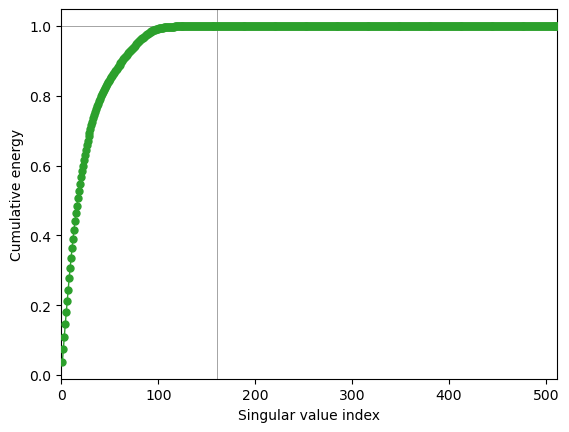

In [5]:
kappa = .999975
r = opinf.pre.cumulative_energy(svdvals, kappa, plot=True)
print(f"r = {r:d} singular values exceed {kappa:.4%} energy")
Vr, _ = opinf.pre.pod_basis(Q_train, r, mode="dense")
print(f"Shape of Vr: {Vr.shape}")

Resultando em 161 autovetores na nossa base reduzida.

Com nossa base reduzida Vr podemos decompor nossos dados no espaço reduzido de Lyapunov (Q_train_). Em seguida, devemos derivar Q_train_, que no nosso caso, será utilizando método de diferenças finitas.

In [6]:
Q_train_ = Vr.T @ Q_train 
Q_train_dot_ = opinf.pre.ddt_uniform(Q_train_, dt, order=6)

Com a biblioteca opinf, devemos definir o tipo do nosso problema. Da equação de KS vimos que possuem três operadores que regem o e PDE, um termo constante (c), um termo linear (A) e um termo quadrático (H). Logo, podemos definir nosso caso como: $dq / dt = c + Aq(t) + H[q(t) ⊗ q(t)]$, onde o operador $⊗$ é o produto de Kronecker baseado em colunas e compacto, ou seja, aplica o produto de kronecker coluna a coluna e desconsidera termos iguais ($a_ij = a_ji$). O tamanho final de uma matriz  $[Q(t) ⊗ Q(t)]$ é $(n(n+1)/2,)$

In [7]:
rom = opinf.ContinuousOpInfROM("cAH")
print(rom)

Reduced-order model structure: dq / dt = c + Aq(t) + H[q(t) ⊗ q(t)]


Agora, para a solução do problema de otimização, devemos estimar os melhores regularizadores, λ1 e λ2. Para isso, precisamos fazer um gridsearch. A função a baixo define a diagonal da matriz 𝚪, que será usada no problema de Least Squares.  

In [8]:
def regularizer(r, λ1, λ2, λ3=None):
    """Return the regularizer that penalizes all operator elements by λ1,
    except for the quadratic operator elements, which are penalized by λ2.
    If λ3 is given, the entries of the cubic operator are penalized by λ3.

    Parameters
    ----------
    r : int
        Dimension of the ROM.
    λ1 : float
        Regularization hyperparameter for the non-quadratic operators.
    λ2 : float
        Regularization hyperparameter for the quadratic operator.
    λ2 : float or None
        Regularization hyperparameter for the cubic operator (if present).

    Returns
    -------
    diag(𝚪) : (d,) ndarray
        Diagonal entries of the dxd regularizer 𝚪.
    """
    r1 =  r
    r2 = r1 + r*(r + 1)//2
    if λ3 is None:
        diag𝚪 = np.full(r2+1, λ1)
        diag𝚪[r1:-1] = λ2
    else:
        r3 = r2 + r*(r + 1)*(r + 2)//6
        diag𝚪 = np.full(r3+1, λ1)
        diag𝚪[r1:r2] = λ2
        diag𝚪[r2:-1] = λ3
    return diag𝚪




A função self.fit() é reponsável por estimar os operadores $\hat{c}, \hat{A} e \hat{H}$, a partir de um problema de minimização least squares:

$min_{\hat{O}}||D\hat{O}^T - R^T||^2 + R(\hat{O})$,

onde D é a matriz de dados contendo os dados de estado do modelo reduzido, que no nosso caso é $\hat{Q}$. $\hat{O}$ é a matriz de operadores, que é o que buscamos neste problema de minimização. Para o caso proposto, buscamos os operadores $\hat{c}$, $\hat{A}$ e $\hat{H}$. Por último, R é a matriz de ordem reduzida da derivada no tempo, no nosso caso $\dot{\hat{Q}}$.

Há ainda o termo de regularização $R(\hat{O})$, que penaliza as entradas dos operadores aprendidos. A regularização promove estabilidade e acurácia para a estimativa dos operaores, prevenindo sobreajuste. Este termo é considerado com os λ1 e λ2 definidos no gridsearch.

A realização do otimização de hiperparâmetros via Gridsearch não foi possível pelo alto custo computacional. Optou-se por selecionar os regularizadores de acordo com os obtidos na literatura.Os valores selecionados foram λ1 e λ2 = $[0.001 , 0.001]$.
Contanto, a implementação do gridsearh está disponível no fim deste notebook.


In [9]:
λ1 = 0.001
λ2 = 0.001
Lamb = regularizer(r,λ1, λ1)
rom.fit(basis=Vr, states=Q_train_, ddts=Q_train_dot_,regularizer =Lamb)


Reduced-order model structure: dq / dt = c + Aq(t) + H[q(t) ⊗ q(t)]
Full-order dimension    n = 512
Reduced-order dimension r = 161

Uma vez estimado os operadores $\hat{c}, \hat{A}$ e $\hat{H}$, podemos integrar a equação diferencial $dq / dt = c + Aq(t) + H[q(t) ⊗ q(t)]$ numéricamente através de métodos de problemas de valor inicial. Neste caso, usaremos o LSODA, que resolve o problema $dy/dt = f$ quando o problema é rígido. Ele seleciona automaticamente entre os métodos de Adams, para casos não rígidos, e BDF, para casos rígidos.

Para testar o modelo, iremos utilizar como condição inicial, o estado final do nosso trainamento. Além disso, devemos decompor o vetor condição inicial na nossa base reduzida.

In [10]:
q0 = Q_train[:,-1]
q0_ = Vr.T @ q0 

In [11]:
Q_ROM = rom.predict(q0_, tt_teste[:5000], method="LSODA")


Finalmente, para avaliarmos a capacidade de predição do nosso modelo, iremos plotá-lo e compará-lo com nosso Q_teste. A escala temporal foi normalizada pela escala de Lyapunov,$t/t_{lyap} = \frac{1}{ \Lambda}$  , onde $\Lambda $ é o expoente de Lyapunov, e foi definido como $0.094$. 

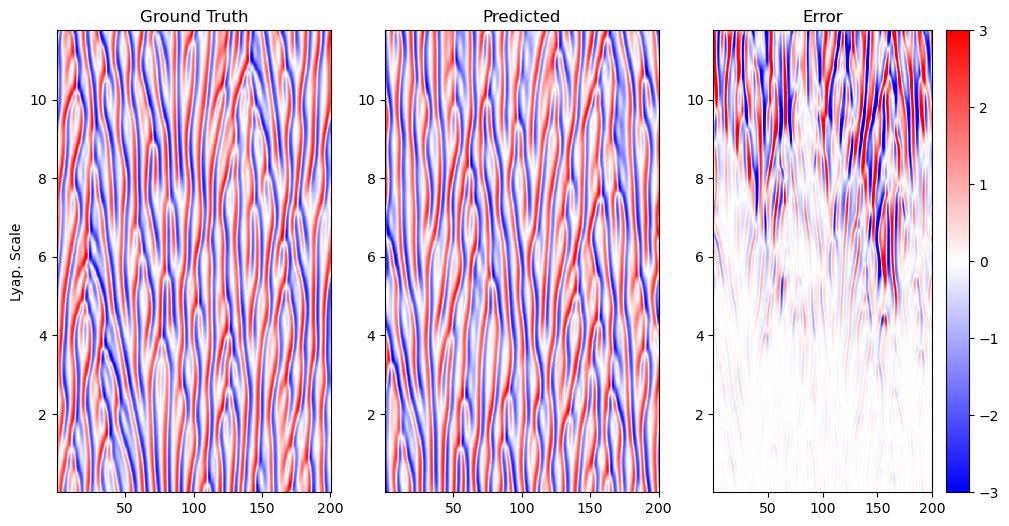

In [21]:
# Plots

Q_trained = Q_ROM.T
N  = 512
LL = 100/(np.pi)
dx = (2*LL*np.pi)/N
h  = 0.25
x  = dx*np.linspace(1,N,N)
l_plot = 500  # tamanho do Plot
lam1 = 0.094
tt_lya = (tt_teste- tt_train[-1]) * lam1



#t = np.arange(0,10000,0.25)
fig , (ax1, ax2, ax3) = plt.subplots(1,3)
fig.set_figheight(6)
fig.set_figwidth(12)
erro = Q_teste.T[:,:l_plot] -  Q_trained[:l_plot,:].T
c = ax1.pcolor(x, tt_lya[:l_plot], Q_train[:,:l_plot].T, cmap ='bwr', vmin=-3,vmax = 3)
ax2.pcolor(x, tt_lya[:l_plot], Q_trained[:l_plot,:], cmap ='bwr', vmin=-3,vmax = 3)
ax3.pcolor(x, tt_lya[:l_plot], erro.T, cmap ='bwr', vmin=-3,vmax = 3)
ax1.set_title('Ground Truth')
ax1.set_ylabel("Lyap. Scale")
ax2.set_title('Predicted')
ax3.set_title('Error')
fig.colorbar(c)

#plt.savefig('fig1.png')

Os resultados apresenteram uma boa predição até $t_{lyap}<4$, o que mostra uma boa aderência com os resultados na literatura.

# Apendice

A baixo, será feito uma busca variando os parâmetros λ1 e λ2. Estes parâmetros serão variados em $log λ_i = 10^{-i}$ com i variando de -3 a 3,  e os erros avaliados. O par com menor erro será o escolhido para gerar as respostas. Idealemente, esta busca deveria abranger uma faixa maior. Em vista o esforço computacional, esta busca é reduzida, buscando buscar resultados obtidos na literatura. Nesta etapa, todos os passos para solução desta EP estão implementados. A fim de uma melhor elucidação, essas etapas serão explicadas nos passos seguintes.

In [22]:
import time
q0 = Q_train[:,0]
q0_ = Vr.T @ q0 

λ1 = [0.001, 0.01, 0.1]
λ2 = [0.001, 0.01, 0.1]

erro_ab = []
erro_rel= []
mse     = []
mse_tot = []
start = time.perf_counter()
for i in λ1:
    for j in λ2:
        start1 = time.perf_counter()
        Lamb = regularizer(r,i, j)
        rom.fit(basis=Vr,states = Q_train_, ddts=Q_train_dot_, regularizer =Lamb)
        finish1 = time.perf_counter()
        print('.fit() ok para ', i, j)
        print(f'finished fit{i, j} in {round(finish1-start1,2)} seconds')
        start1 = time.perf_counter()
        Q_ROM = rom.predict(q0_, tt_train, method="LSODA")
        print(Q_ROM.shape)
        finish1 = time.perf_counter()
        print('.predict() ok para ', i, j)
        print(f'finished predict {i, j} in {round(finish1-start1,2)} seconds')
        [er_ab, er_rel] = opinf.post.frobenius_error(Q_train[:,:len(Q_ROM[0,:])],Q_ROM)    
        erro_ab.append(er_ab)
        erro_rel.append(er_rel)
        mse.append((np.square(Q_train[:,:len(Q_ROM[0,:-31])] - Q_ROM[:,:-31])).mean(axis=0))
        mse_tot.append((np.square(Q_train[:,:len(Q_ROM[0,:])] - Q_ROM)).mean(axis=None))
print('Lambda 1 =', i , 'Lambda 2 =', j,'erro = ', mse_tot[-1])  
print('MSE = ', mse_tot)  
finish = time.perf_counter()
print(f'finished gridsearch in {round(finish-start,2)} seconds')

MemoryError: Unable to allocate 16.5 GiB for an array with shape (13041, 170000) and data type float64

Para analisar os erros do gridsearch, propusemos um gráfico colormap para ver a interação entre os 9 casos testados.

In [ ]:
erro = np.array([mse_tot[0],mse_tot[1], mse_tot[2]], [mse_tot[3],mse_tot[4], mse_tot[5]], [mse_tot[6],mse_tot[7], mse_tot[8]])
fig, ax = plt.subplots()
#fig.set_figheight(4)
fig.set_figwidth(16)
c = ax1.pcolor(λ1,λ2, erro  cmap ='GnBu', vmin=-3,vmax = 3)
fig.colorbar(c)


